Specifically chosen a TF version that is compatible with the current version of MLflow

In [ ]:
pip install tensorflow==2.11.0

In [1]:
import tensorflow as tf

print(tf.__version__)

2.13.0-rc1


In [2]:
import mlflow
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

from mlflow.models.signature import infer_signature

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [4]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [5]:
class_names = [
    'T-shirt/top', 
    'Trouser', 
    'Pullover', 
    'Dress', 
    'Coat',
    'Sandal', 
    'Shirt', 
    'Sneaker', 
    'Bag', 
    'Ankle boot'
]

Taking a look at unnormalised raw image

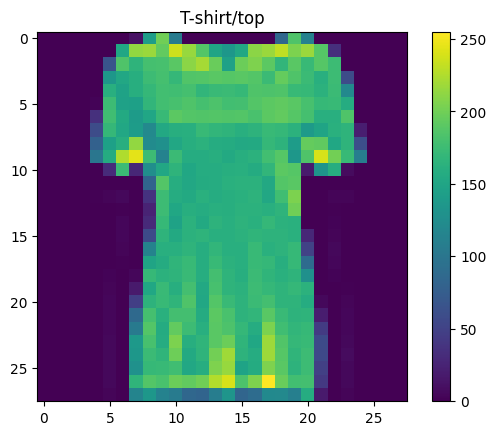

In [6]:
plt.figure()

plt.imshow(train_images[10])
plt.colorbar()
plt.title(class_names[train_labels[10]])

plt.show()

Images are normalised and a set is plotted

In [7]:
train_images = train_images / 255.0

test_images = test_images / 255.0

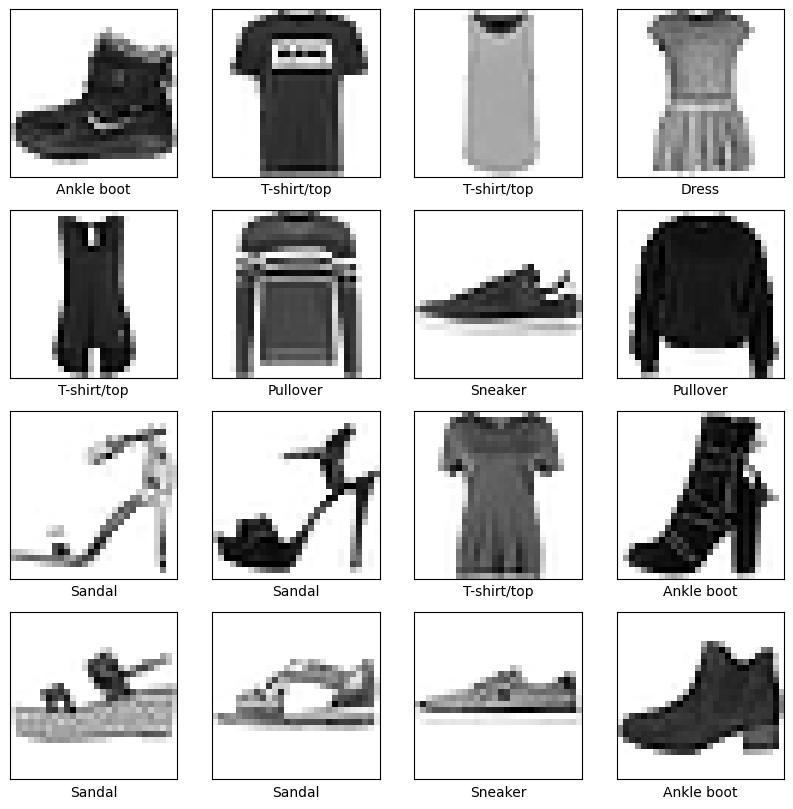

In [8]:
plt.figure(figsize = (10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)

    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    plt.imshow(train_images[i], cmap = plt.cm.binary)
    
    plt.xlabel(class_names[train_labels[i]])

plt.show()

#### Notes

Note how an image is represented in the normalized form

In [9]:
train_images[2]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.08627451,
        0.4627451 , 0.09411765, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.18823529, 0.34509804, 0.01960784,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.04705882, 0.39215686,
        0.83137255, 0.80392157, 0.7254902 , 0.70196078, 0.67843137,
        0.72941176, 0.75686275, 0.86666667, 0.55686275, 0.33333333,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.33333333,
        0.29803922, 0.78039216, 0.88235294, 0.97254902, 1.        ,
        0.93333333, 0.8862

Creating 'Fashion_images_prediction' experiment

In [10]:
experiment_id = mlflow.create_experiment(name = 'fashion_images_prediction_tf')

mlflow.set_experiment(experiment_name= 'fashion_images_prediction_tf')

<Experiment: artifact_location='file:///Users/vitthalsrinivasan/Desktop/iMovieLibrary/Skillsoft/MLOps/MLFlow/final_code/demo_07_ManagingTensorFlowModels/mlruns/418695207339302421', creation_time=1687407923385, experiment_id='418695207339302421', last_update_time=1687407923385, lifecycle_stage='active', name='fashion_images_prediction_tf', tags={}>

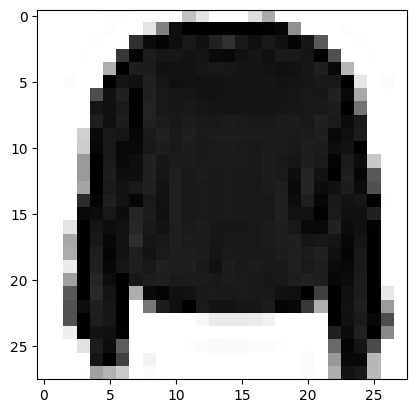

In [11]:
fig1 = plt.imshow(train_images[7], cmap = plt.cm.binary)

Same image converted to an Image object using PIL

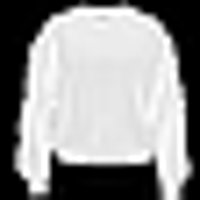

In [12]:
from PIL import Image

im = Image.fromarray(np.uint8(train_images[7] * 255)).resize((200, 200))

im

By using log_image we can log images to the experiment run, All category of images can be seen logged

We log 30 images but the images will be overwritten if they have the same label. The 30 is to ensure that we have images of a number of different classes

In [13]:
with mlflow.start_run():
    for i in range(100, 130):
        mlflow.log_image(
            Image.fromarray(np.uint8(train_images[i] * 255)).resize((200, 200)) , 
            f"{class_names[train_labels[i]]}.png"
        )

Input example specified while logging the model

We are training our model and parameters are getting autologged. We have disabled models logging so that model signature and model is explicitly logged

Thus you can explicitly turn on and off what you want to log when you use autolog

In [15]:
mlflow.tensorflow.autolog(log_models = False)

with mlflow.start_run() as tf_run:
    
    # batch_size, height, width, channels
    X_train = train_images.reshape((train_images.shape[0], 28, 28, 1))
    X_test = test_images.reshape((test_images.shape[0], 28, 28, 1))
    
    y_train = to_categorical(train_labels)
    y_test = to_categorical(test_labels)
    
    # input_example shape (1, 28, 28, 1)
    input_example = np.expand_dims(X_train[0], axis = 0)
    
    model = Sequential()
    
    # Convolutional + pooling layer
    model.add(
        Conv2D(
            32, kernel_size = (3, 3),
            activation = 'relu',
            kernel_initializer = 'he_normal',
            input_shape = (28, 28, 1)
        )
    )
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    # Convolution + pooling layer
    model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    
    # Convolution + pooling layer
    model.add(Conv2D(128, (3, 3), activation = 'relu'))
    model.add(Dropout(0.4))

    # Linear layer
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.3))
    
    # Softmax to output class probabilities
    model.add(Dense(10, activation = 'softmax'))

    model.compile(
        loss = keras.losses.categorical_crossentropy, 
        optimizer = keras.optimizers.Adam(),
        metrics = ['accuracy']
    )
    
    model.fit(X_train, y_train,
              epochs = 10, batch_size = 32, 
              validation_data = (X_test, y_test))

    signature = infer_signature(X_test, model.predict(X_test))
    
    mlflow.tensorflow.log_model(
        model, 'fashion_mnist_cnn', 
        signature = signature, 
        input_example = input_example
    )

2023/06/22 09:55:46 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


Epoch 1/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.6059 - accuracy: 0.7741 - val_loss: 0.3762 - val_accuracy: 0.8585
Epoch 2/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.4008 - accuracy: 0.8548 - val_loss: 0.3254 - val_accuracy: 0.8808
Epoch 3/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3533 - accuracy: 0.8717 - val_loss: 0.2996 - val_accuracy: 0.8891
Epoch 4/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3285 - accuracy: 0.8808 - val_loss: 0.2791 - val_accuracy: 0.8967
Epoch 5/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.3116 - accuracy: 0.8861 - val_loss: 0.2703 - val_accuracy: 0.9011
Epoch 6/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.3009 - accuracy: 0.8903 - val_loss: 0.2624 - val_accuracy: 0.9022
Epoch 7/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.2914 - accuracy: 0.8929 - val_loss: 0.2608 - val_ac

INFO:tensorflow:Assets written to: /var/folders/8s/n93wlyld00s_n12w15m5psf00000gn/T/tmp2g01_kyf/model/data/model/assets
/Users/vitthalsrinivasan/Desktop/iMovieLibrary/Skillsoft/MLOps/MLFlow/final_code/mlflow_venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


#### Notes:

Saved model format for TF
https://www.tensorflow.org/guide/saved_model

### TODO Recording

- Go to the MLflow UI
- Click through to the run
- Open the different sections and show
- Show the artifacts logged (click on each file)
- Note the signature in the MLmodel file

In [17]:
tf_run.info.run_id

'5d8563720f0841eabf500a261f62367f'

Note that this code is just a tweaked version of the sample code included with the run

The output comprises of probabilities for each class

In [18]:
logged_model = f'runs:/{tf_run.info.run_id}/fashion_mnist_cnn'

loaded_model = mlflow.pyfunc.load_model(logged_model)

predictions = loaded_model.predict(X_test)

predictions[:10]

2023/06/22 09:59:24 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.4.1, required: mlflow==2.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
/Users/vitthalsrinivasan/Desktop/iMovieLibrary/Skillsoft/MLOps/MLFlow/final_code/mlflow_venv/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


313/313 [==============================] - 0s 1ms/step


array([[1.96327655e-12, 7.13171519e-14, 8.87619925e-12, 2.33619276e-13,
        4.17805070e-12, 2.09166719e-05, 1.05479521e-10, 1.01678408e-04,
        5.19224352e-09, 9.99877334e-01],
       [1.79668968e-05, 2.61603174e-12, 9.99354064e-01, 4.64771693e-10,
        3.59019585e-04, 4.88928030e-17, 2.69004930e-04, 1.07814897e-18,
        2.85135832e-10, 1.82098396e-19],
       [1.92745524e-11, 1.00000000e+00, 6.37150516e-14, 7.03276716e-12,
        3.15895822e-14, 3.50098863e-20, 8.93289240e-13, 8.89634435e-26,
        6.89863443e-16, 2.86783693e-23],
       [1.43522505e-09, 1.00000000e+00, 8.45130389e-12, 1.19024968e-09,
        1.29621088e-11, 8.25780824e-17, 2.27826133e-10, 4.93646728e-21,
        1.50868250e-13, 2.61083198e-19],
       [1.39974818e-01, 1.67207315e-06, 1.23735499e-02, 4.13771486e-03,
        2.78985705e-02, 1.06595763e-08, 8.15608680e-01, 4.68327460e-11,
        4.97267365e-06, 3.45487416e-09],
       [2.99257263e-09, 1.00000000e+00, 1.93763981e-11, 7.23598889e-11,
   

Looking at one sample prediction

In [19]:
predictions[0]

array([1.9632765e-12, 7.1317152e-14, 8.8761993e-12, 2.3361928e-13,
       4.1780507e-12, 2.0916672e-05, 1.0547952e-10, 1.0167841e-04,
       5.1922435e-09, 9.9987733e-01], dtype=float32)

In [20]:
class_names[np.argmax(predictions[0])]

'Ankle boot'

In [21]:
predictions[17]

array([1.1807897e-02, 6.0827390e-04, 1.1811355e-01, 6.1079790e-04,
       4.6560144e-01, 1.5883971e-06, 4.0208739e-01, 1.4488467e-07,
       1.1655476e-03, 3.2534035e-06], dtype=float32)

In [22]:
class_names[np.argmax(predictions[17])]

'Coat'

For a batch of say 50 images, We compare the predicted and actual labels

In [23]:
def show(idx, title):
    
    plt.figure()
    plt.imshow(X_test[idx].reshape(28, 28))
    
    plt.axis('off')
    plt.title('\n\n{}'.format(title), fontdict = {'size': 16})

/var/folders/8s/n93wlyld00s_n12w15m5psf00000gn/T/ipykernel_50356/2967998030.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


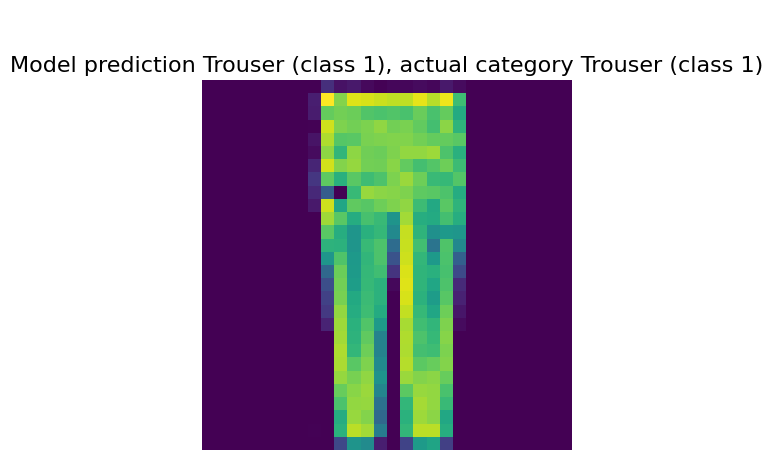

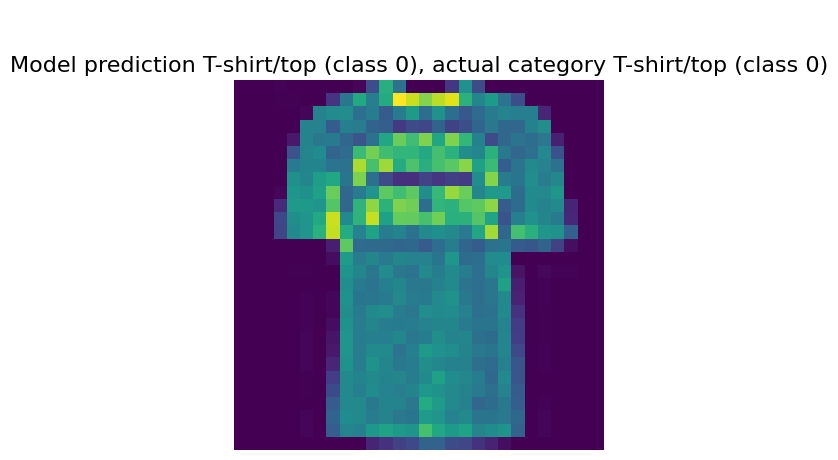

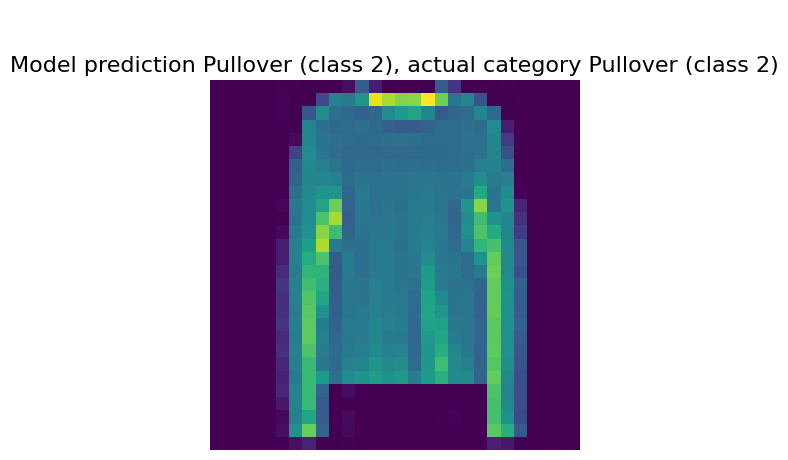

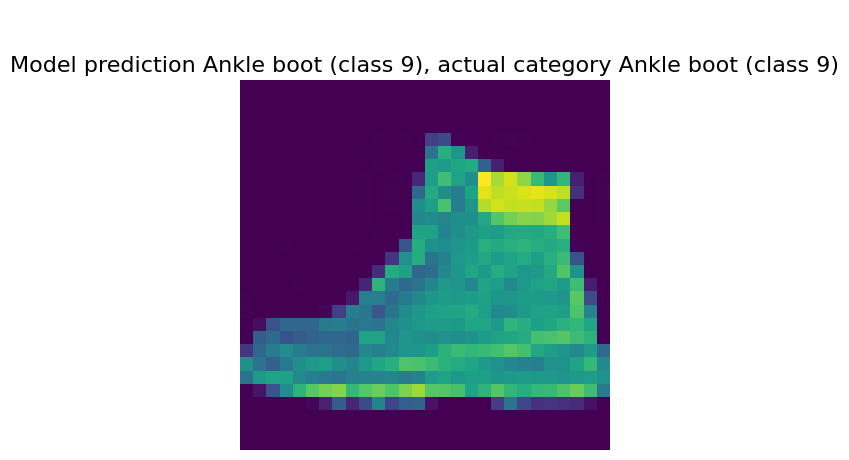

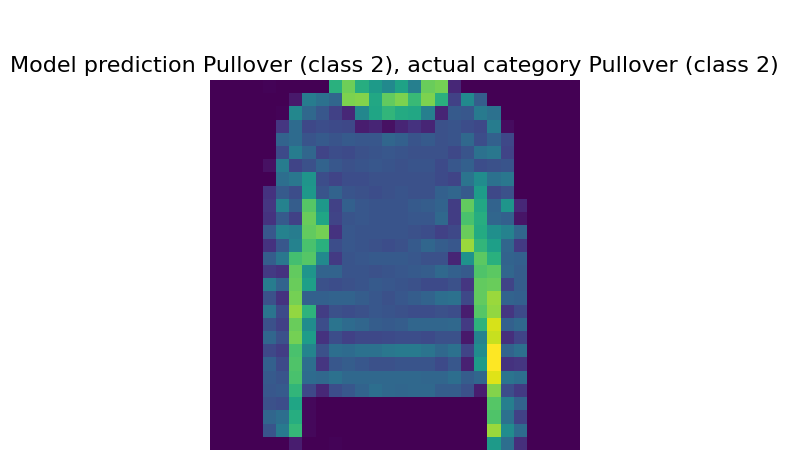

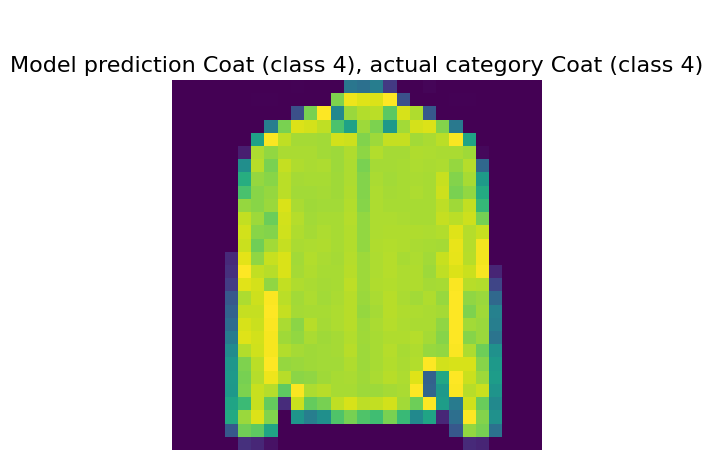

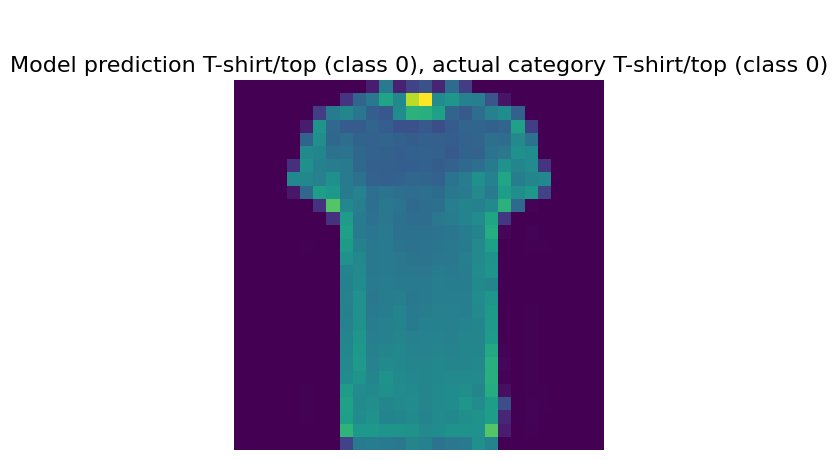

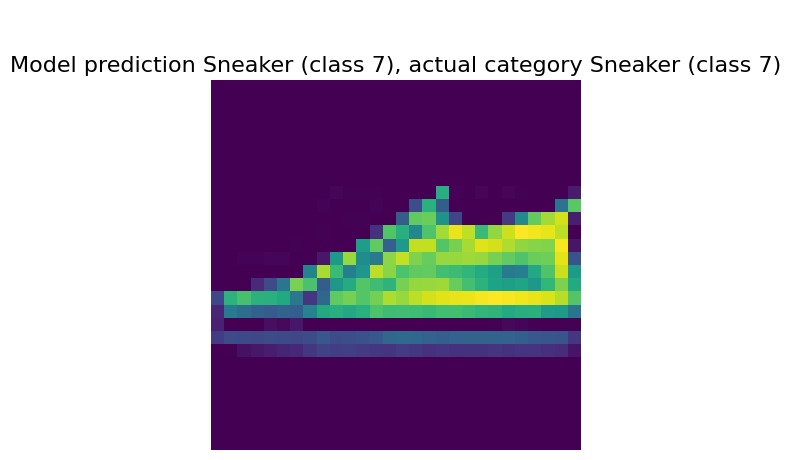

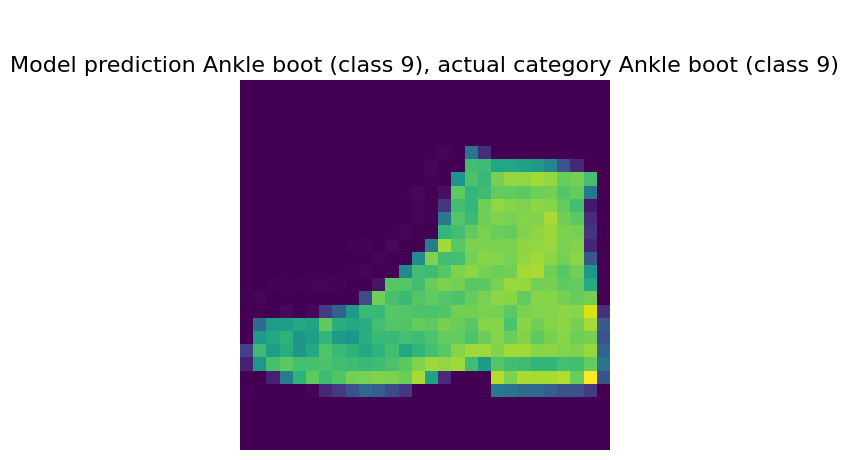

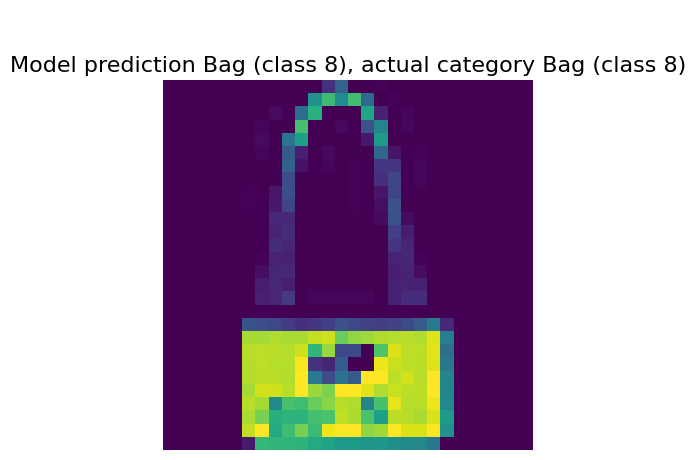

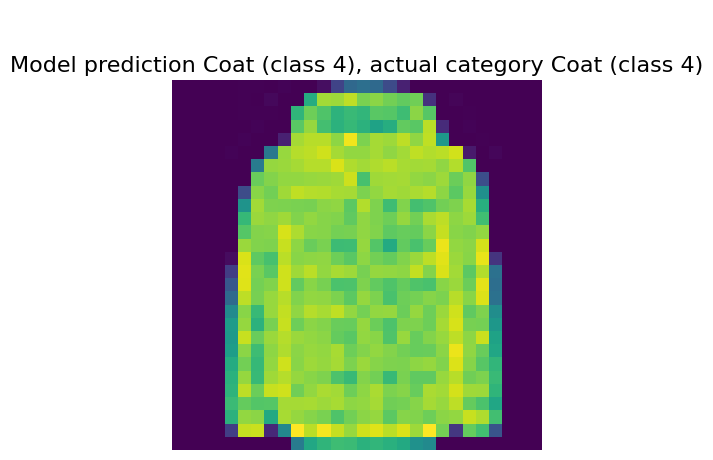

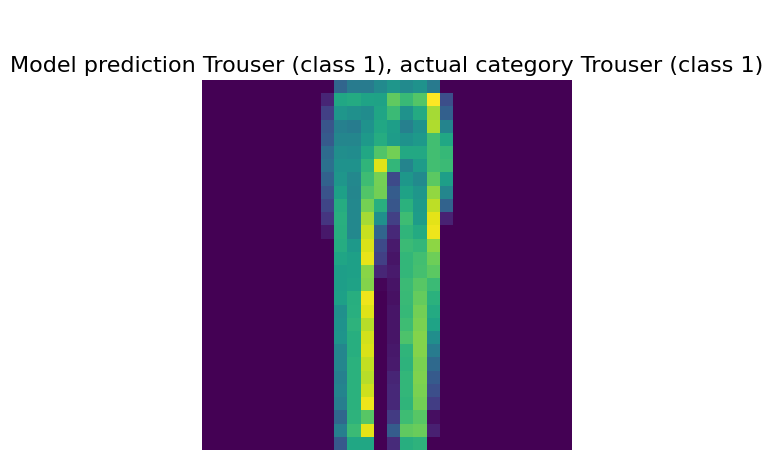

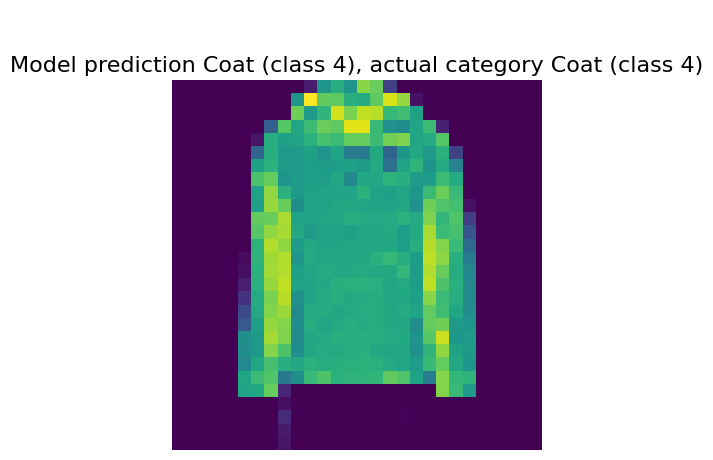

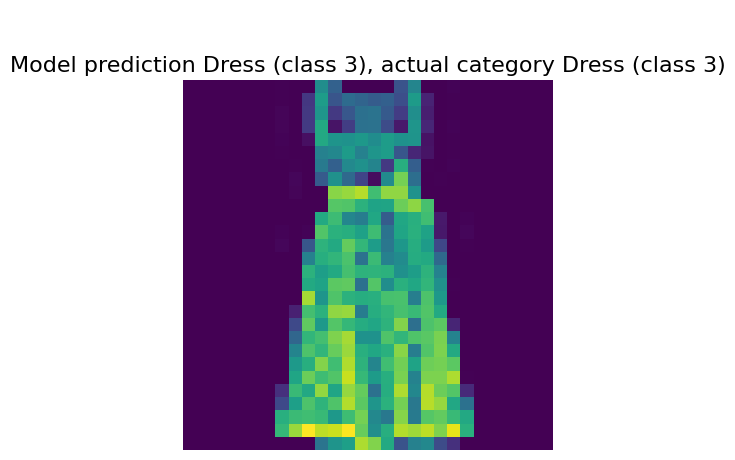

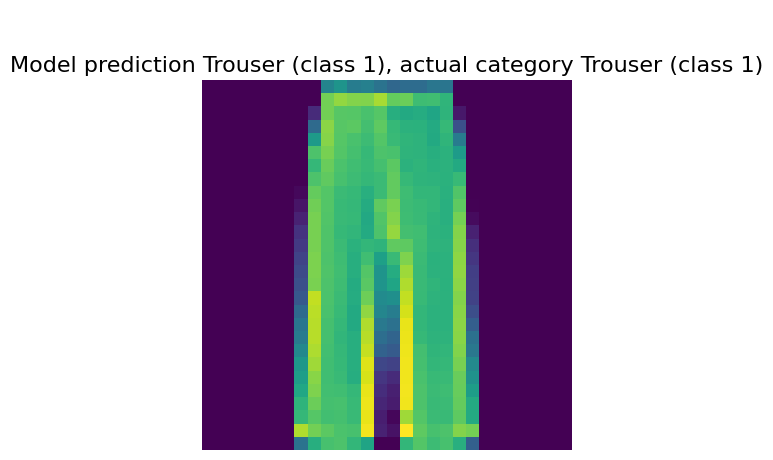

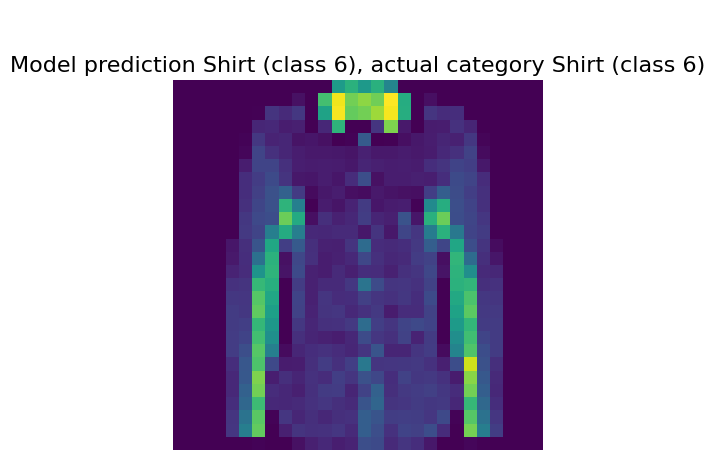

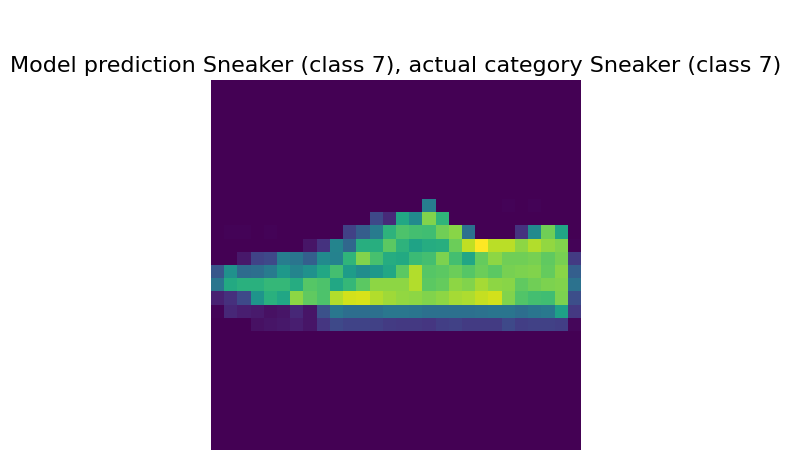

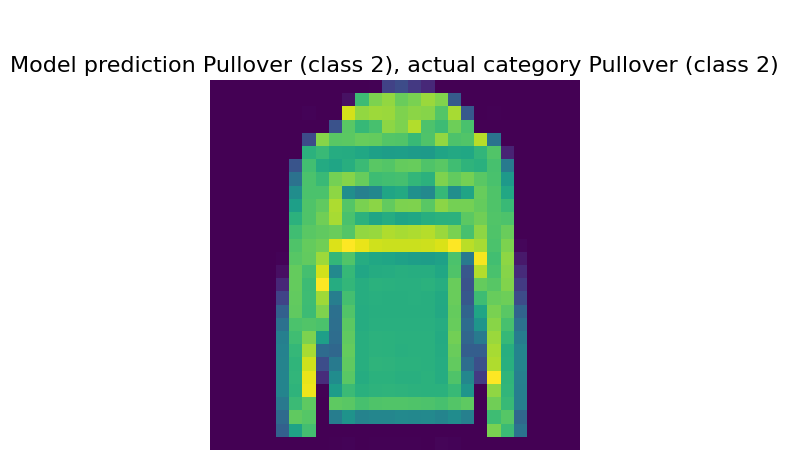

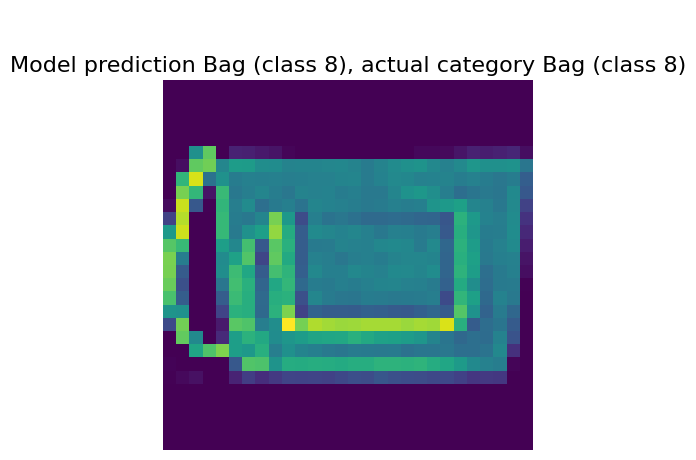

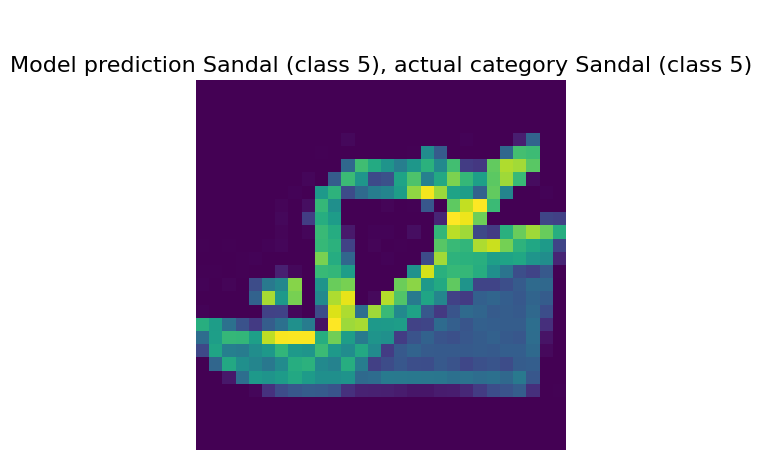

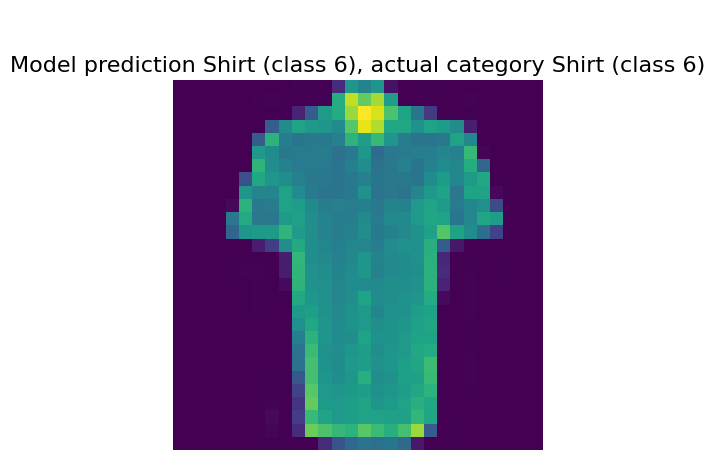

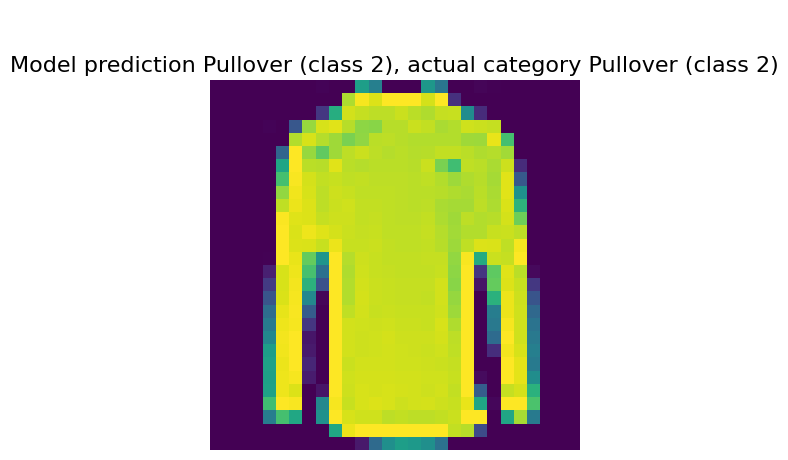

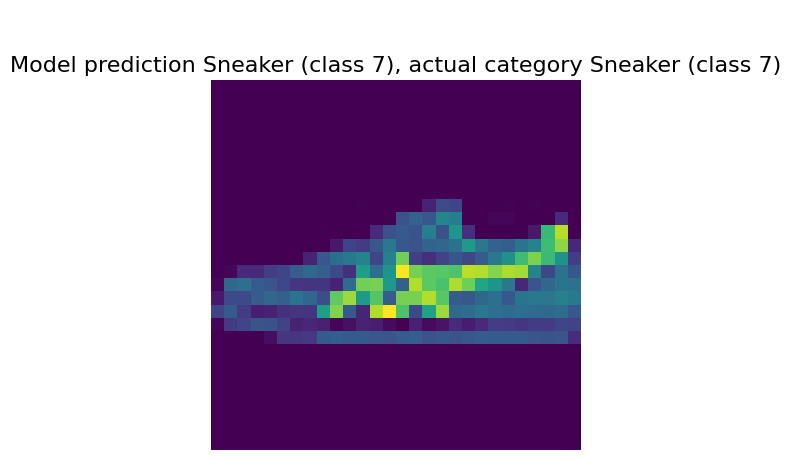

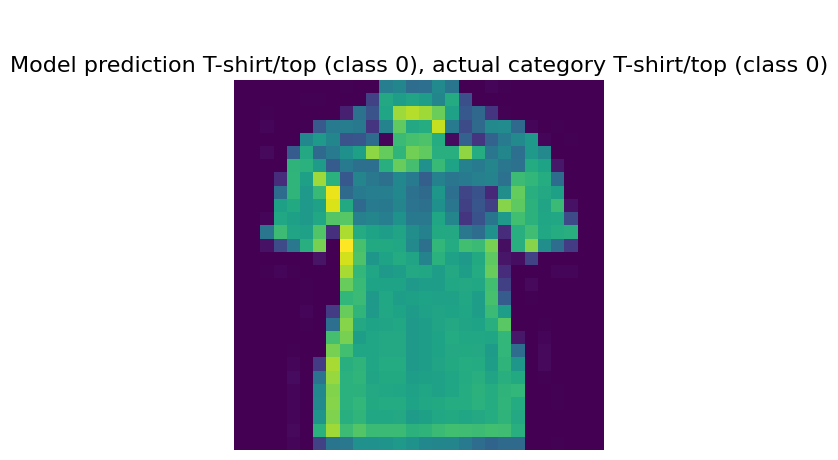

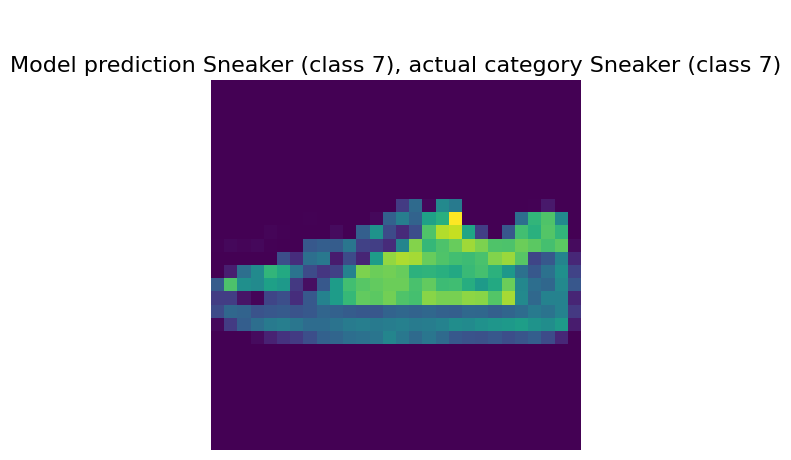

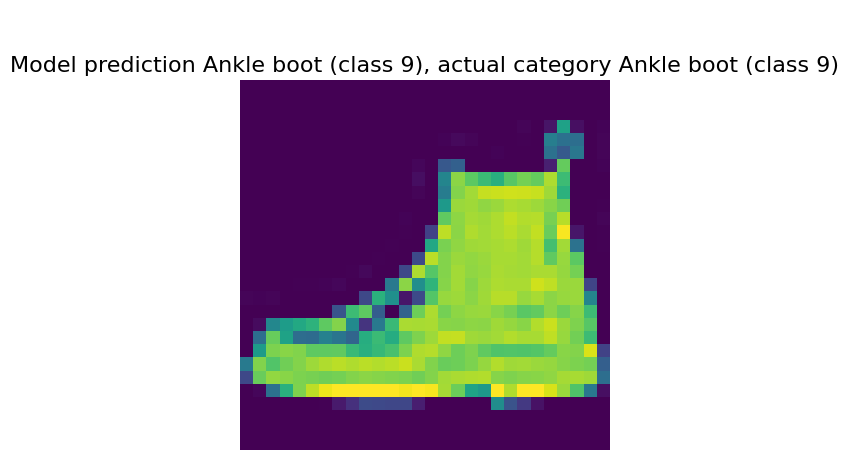

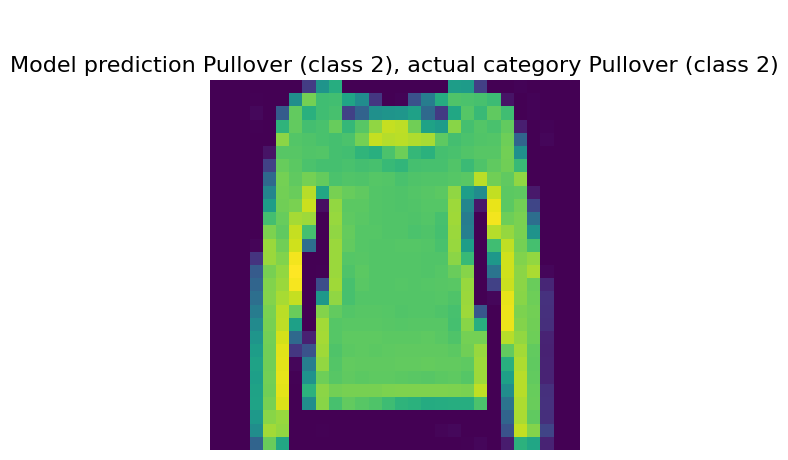

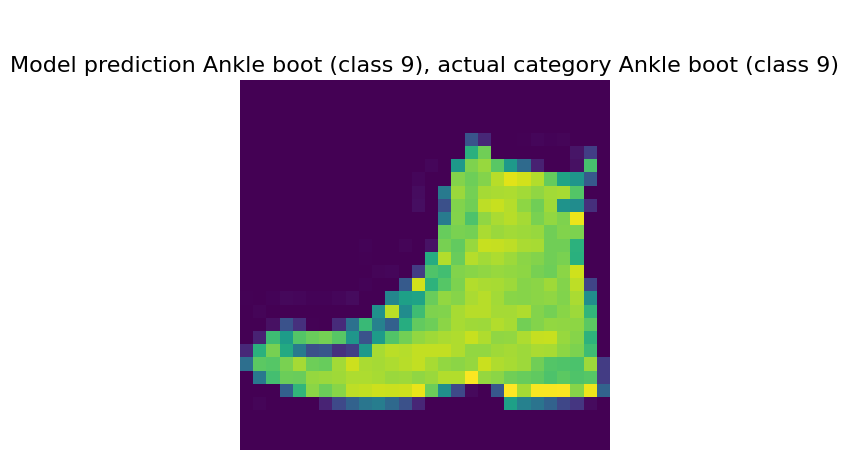

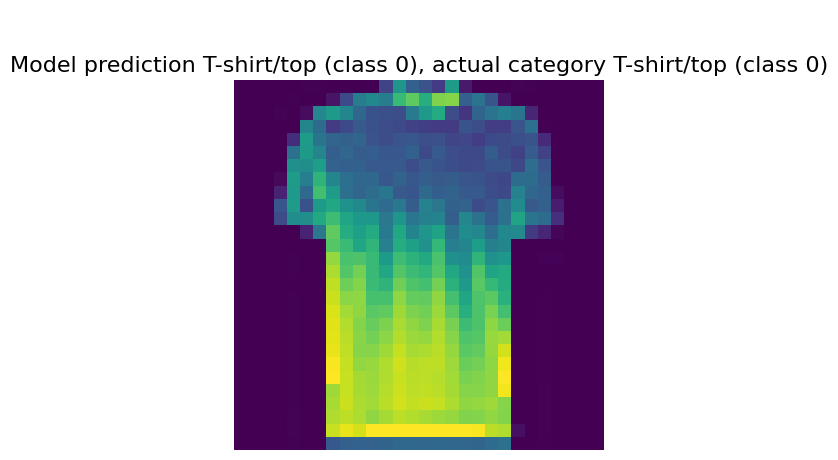

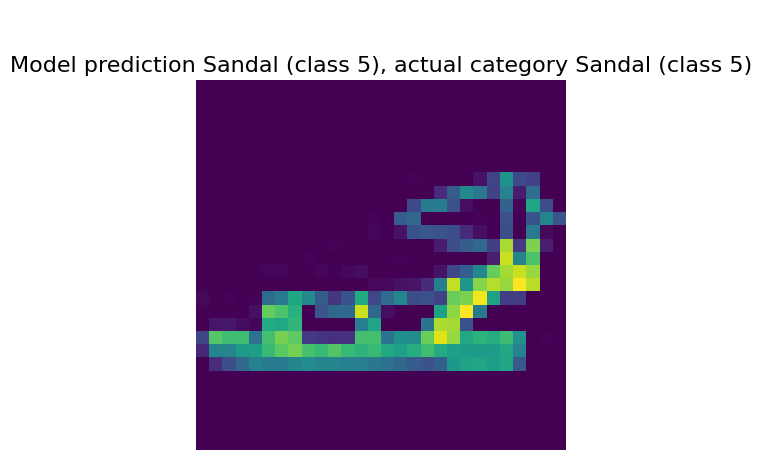

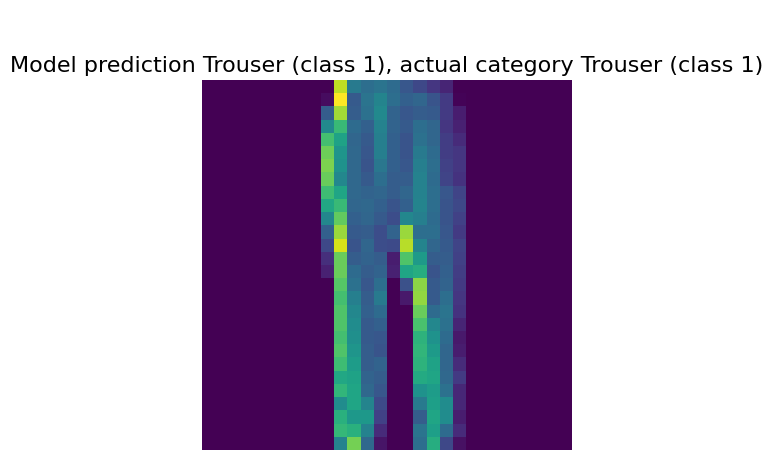

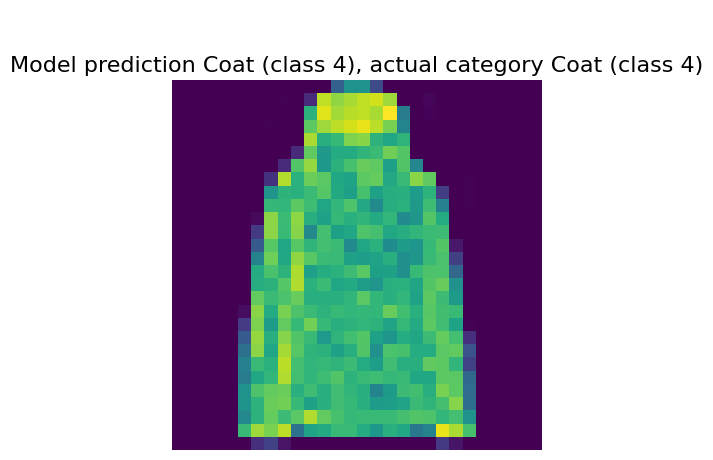

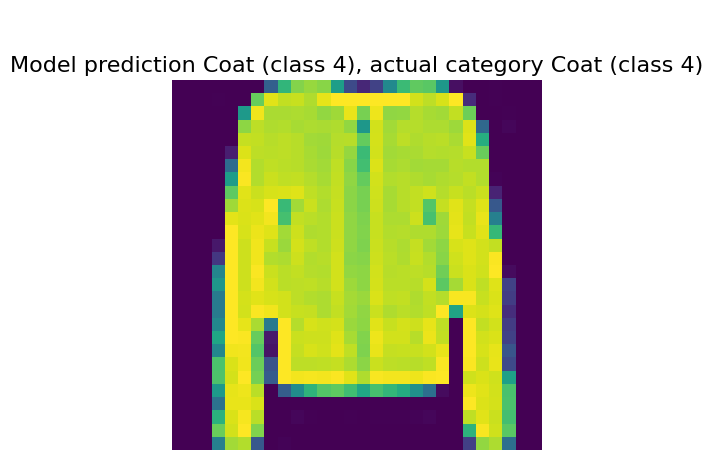

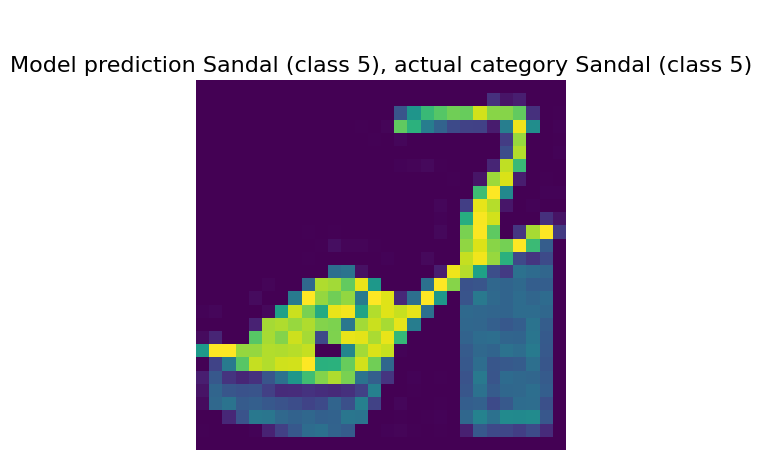

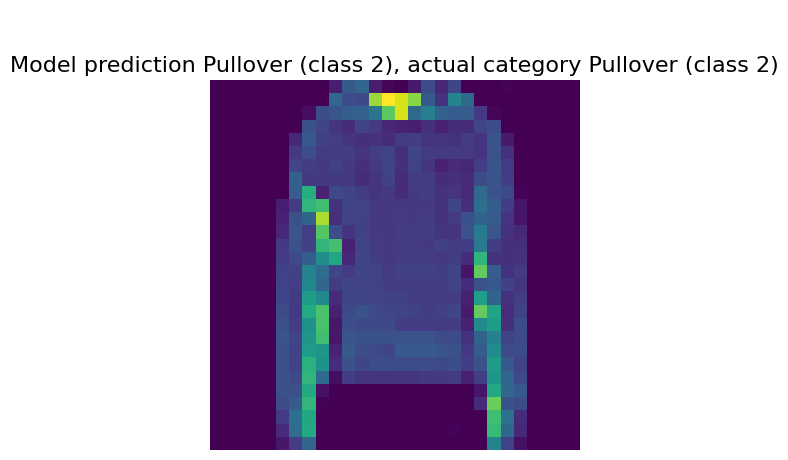

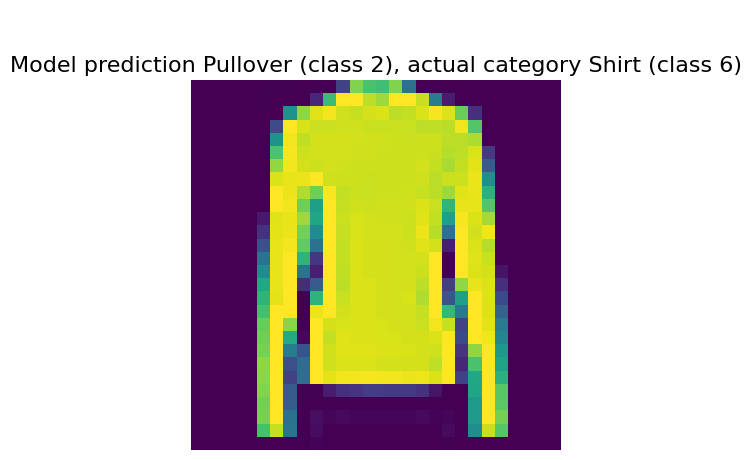

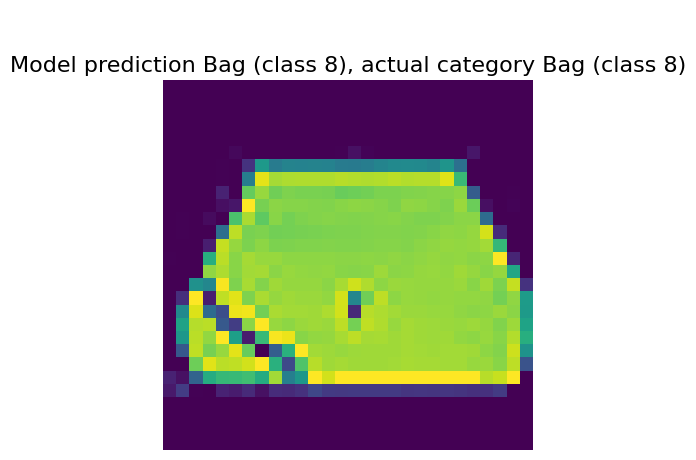

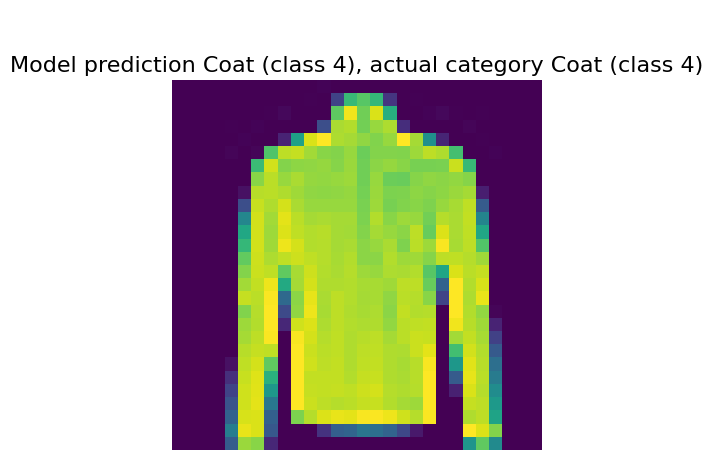

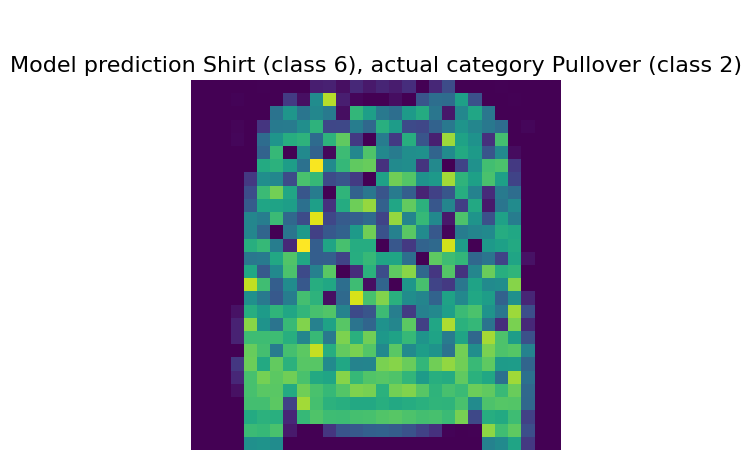

In [24]:
for i in range(200, 250):
    
    predicted_class = np.argmax(predictions[i])
    actual_class = test_labels[i]
                                
    show(i, 'Model prediction {} (class {}), actual category {} (class {})'.format(
          class_names[predicted_class], predicted_class,
          class_names[actual_class], actual_class
    ))

### TODO Recording:

- Switch over to the MLflow UI
- Select the fashion_mnist_cnn/ folder under artifacts
- Click on "Register model"
- Choose create new model and specify the name of the model "fashion_mnist_prediction_model"
- Register the model
- Go to models and check that Version 1 has been registered
- Move this model to the "Staging" stage

In [ ]:
from mlflow.tracking import MlflowClient
 
client = MlflowClient()

client.transition_model_version_stage(
  name = "fashion_mnist_prediction_model",
  version = 1,
  stage = 'Production',
)

In [25]:
tf_run.info.run_id

'5d8563720f0841eabf500a261f62367f'

## Serving models locally

### TODO Recording:

- Switch to the terminal window in the venv
- Make sure that you are in the ~/projects/mlflow folder
- Run

`ls -l`

- You should see a folder for the best run from the cell above
- Come back to this notebook and run this command

`mlflow models serve -m runs:/<run_id>/fashion_mnist_cnn --env-manager local --host 127.0.0.1:1234`

- Come back to the notebook to get predictions

Input data for prediction is obtained

In [30]:
X_test[7].shape

(28, 28, 1)

In [33]:
np.expand_dims(X_test[7], axis = 0).shape

(1, 28, 28, 1)

In [34]:
import json

# Get the tensor in the shape [-1, 28, 28, 1] and create a list of these tensors
# expand_dims adds an extra empty dimension at index 0 
# converting [28, 28, 1] -> [-1, 28, 28, 1]
data = json.dumps({"instances": np.expand_dims(X_test[7], axis = 0).tolist()})

data

'{"instances": [[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.00784313725490196], [0.011764705882352941], [0.0], [0.0], [0.3686274509803922], [0.592156862745098], [0.6078431372549019], [0.5411764705882353], [0.3843137254901961], [0.0], [0.0], [0.00392156862745098], [0.0], [0.0], [0.0], [0.00392156862745098], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.1803921568627451], [1.0], [0.7725490196078432], [0.7686274509803922], [0.7490196078431373], [0.984313725490196], [0.011764705882352941], [0.0], [0.0], [0.00392156862745098], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.1568627450980392], [0.24705882352941178], [0.1607843137254902], [0.21176470588235294], [0.7176470588235294], [0.7725490196078432], [0.7098039215686275], [0.37254901960784315], [0.2549019607843137], [0.49019607843137253], [0.023529411764705882], [0.0], [0.0], [0.0], [0.0], [

In [ ]:
!curl http://127.0.0.1:1234/invocations -H 'Content-Type: application/json' \
        -d '<paste_json_here>'

### TODO Recording:

- Copy over the prediction output and paste it down below in the string

In [ ]:
predictions = json.loads(
    '<paste prediction string here>'
)['predictions'][0]

predictions

In [ ]:
class_names[np.argmax(predictions)]

### Azure ml working deployment sample input

Installing packages required to work with Azure ML studio

In [ ]:
pip install azureml-core

In [ ]:
pip install azure-ai-ml azure-identity

In [ ]:
pip install azureml-mlflow

In [1]:
from azureml.core import Workspace

ws = Workspace.create(
    name = "loony-mlflow-tf-ws",
    subscription_id = "0fec7b07-1efc-48ea-b142-6ed379f356be",
    resource_group = "loony-mlflow-rg",
    create_resource_group = False,
    location = 'eastus'
)

Deploying KeyVault with name loonymlfkeyvault73b22660.
Deploying AppInsights with name loonymlfinsights33e3566b.
Deployed AppInsights with name loonymlfinsights33e3566b. Took 10.9 seconds.
Deploying StorageAccount with name loonymlfstorage14daaca84.
Deployed KeyVault with name loonymlfkeyvault73b22660. Took 28.23 seconds.
Deployed StorageAccount with name loonymlfstorage14daaca84. Took 33.21 seconds.
Deploying Workspace with name loony-mlflow-ws.
Deployed Workspace with name loony-mlflow-ws. Took 26.57 seconds.


### TODO Recording:

- Go to the Azure portal
- In Azure Machine Learning show that the loony-mlflow-ws has been created
- Click through to the workspace
- Launch Azure ML Studio

##### MLflow UI
- Now go to the MLflow UI
- Go to Experiments -> fund the latest run
- In the artifacts you should be able to see the full path of where the model is deployed
- Click on copy so you have that path
- We will need this path in the cell below
- We do not need the file:// prefix, path should start with '/Users/'

In [2]:
from azureml.core.model import Model

model = Model.register(
    workspace=ws, 
    model_path='<model_path>', 
    model_name="fashion_mnist_classification"
)

Registering model fashion_mnist_classification


### TODO Recording

- After registering the model go to the Azure Portal
- In Azure ML Studio click on "Models" on the left hand side
- Show the model registered there
- Click through to the model and show details
- From the top tabs click on Versions
- Click on Artifacts and select the model/ folder and show that the MLflow artifacts are here
- Click on Endpoints and there should be no endpoints here

In [3]:
import json
from mlflow.deployments import get_deploy_client

# Create the deployment configuration.
# If no deployment configuration is provided, 
# then the deployment will happen using ACI (Azure Container Instance).
deploy_config = {"computeType": "aci"}

# Write the deployment configuration into a file.
deployment_config_path = "deployment_config.json"

with open(deployment_config_path, "w") as outfile:
    outfile.write(json.dumps(deploy_config))

### TODO Recording:

- Go to the Azure Portal to the loony-mlflow-ws
- At the top right there will be an MLflow tracking URI
- Copy that over and paste it into the cell below

In [5]:
import mlflow

# Set the tracking uri in the deployment client.
client = get_deploy_client("<ws_tracking_url>")

# Set the tracking URI for the model
mlflow.set_tracking_uri("<ws_tracking_url>")

In [ ]:
config = {"deploy-config-file": deployment_config_path}

model_name = "fashion_mnist_classification"
model_version = 1

client.create_deployment(
    model_uri = f"models:/{model_name}/{model_version}",
    config = config,
    name = "fmnist-aci-deployment",
)

### TODO Recording

- Go to Azure Portal
- Click on Endpoints at the left hand side
- Show that there is one endpoint there
- Click through and show the the endpoint is in the process of being created
- Stay on the Azure portal till the end point is Healthy - will take 20-25 minutes
- Copy over the REST endpoint (will need it in the cell below)

Endpoint consumed for getting prediction

In [ ]:
import urllib.request
import json
import os
import ssl

def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and \
        not os.environ.get('PYTHONHTTPSVERIFY', '') and \
        getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

# this line is needed if you use self-signed certificate in your scoring service.
allowSelfSignedHttps(True) 

# Request data goes here
# The example below assumes JSON formatting which may be updated
# depending on the format your endpoint expects.

data =  {
  "input_data":[[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.050980392156862744], [0.2627450980392157], [0.0], [0.0], [0.0], [0.0], [0.19607843137254902], [0.14901960784313725], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.03137254901960784], [0.47058823529411764], [0.8196078431372549], [0.8862745098039215], [0.9686274509803922], [0.9294117647058824], [1.0], [1.0], [1.0], [0.9686274509803922], [0.9333333333333333], [0.9215686274509803], [0.6745098039215687], [0.2823529411764706], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.5372549019607843], [0.9372549019607843], [0.9882352941176471], [0.9529411764705882], [0.9176470588235294], [0.8980392156862745], [0.9333333333333333], [0.9568627450980393], [0.9647058823529412], [0.9411764705882353], [0.9019607843137255], [0.9098039215686274], [0.9372549019607843], [0.9725490196078431], [0.984313725490196], [0.7607843137254902], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.4], [1.0], [0.9058823529411765], [0.8941176470588236], [0.8901960784313725], [0.8941176470588236], [0.9137254901960784], [0.9019607843137255], [0.9019607843137255], [0.8980392156862745], [0.8941176470588236], [0.9098039215686274], [0.9098039215686274], [0.9058823529411765], [0.8901960784313725], [0.8784313725490196], [0.9882352941176471], [0.7019607843137254], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.9137254901960784], [0.9450980392156862], [0.8980392156862745], [0.9058823529411765], [1.0], [1.0], [0.9333333333333333], [0.9058823529411765], [0.8901960784313725], [0.9333333333333333], [0.9647058823529412], [0.8941176470588236], [0.9019607843137255], [0.8901960784313725], [0.9176470588235294], [0.9215686274509803], [0.8980392156862745], [0.9450980392156862], [0.0784313725490196], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.9725490196078431], [0.9450980392156862], [0.9058823529411765], [1.0], [0.5843137254901961], [0.1843137254901961], [0.9882352941176471], [0.8941176470588236], [1.0], [0.9490196078431372], [0.8470588235294118], [0.9333333333333333], [0.9098039215686274], [1.0], [0.8941176470588236], [0.8627450980392157], [0.9176470588235294], [0.9803921568627451], [0.21176470588235294], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.9411764705882353], [0.9098039215686274], [1.0], [0.058823529411764705], [0.0], [1.0], [0.9294117647058824], [0.7490196078431373], [0.0], [0.0], [0.8392156862745098], [1.0], [0.050980392156862744], [0.4823529411764706], [1.0], [0.9176470588235294], [0.9882352941176471], [0.4470588235294118], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.023529411764705882], [1.0], [0.9333333333333333], [0.9372549019607843], [1.0], [0.6941176470588235], [0.0], [1.0], [1.0], [0.0], [0.5098039215686274], [0.4549019607843137], [0.1843137254901961], [0.2549019607843137], [0.16862745098039217], [0.1450980392156863], [1.0], [0.9254901960784314], [0.9764705882352941], [0.6352941176470588], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.12549019607843137], [1.0], [0.9254901960784314], [0.9607843137254902], [1.0], [0.8], [0.0], [1.0], [0.32941176470588235], [0.0], [0.1450980392156863], [0.10980392156862745], [0.12156862745098039], [0.0], [0.09803921568627451], [0.050980392156862744], [1.0], [0.9254901960784314], [0.9764705882352941], [0.7803921568627451], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.20784313725490197], [1.0], [0.9254901960784314], [0.9803921568627451], [0.9803921568627451], [0.9058823529411765], [0.00784313725490196], [1.0], [0.08235294117647059], [0.0], [0.8666666666666667], [1.0], [0.9254901960784314], [0.21176470588235294], [0.9607843137254902], [0.7764705882352941], [0.9529411764705882], [0.9333333333333333], [0.9607843137254902], [0.8745098039215686], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.3137254901960784], [1.0], [0.9294117647058824], [0.9803921568627451], [0.9411764705882353], [1.0], [0.0], [0.0], [0.15294117647058825], [0.615686274509804], [0.0], [0.0], [0.8431372549019608], [0.3686274509803922], [0.0784313725490196], [0.49411764705882355], [1.0], [0.9294117647058824], [0.9372549019607843], [0.9803921568627451], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.396078431372549], [1.0], [0.9215686274509803], [0.9921568627450981], [0.9568627450980393], [0.9529411764705882], [0.5215686274509804], [0.5411764705882353], [0.8156862745098039], [1.0], [0.788235294117647], [0.8392156862745098], [1.0], [0.9019607843137255], [0.027450980392156862], [0.6823529411764706], [1.0], [0.9411764705882353], [0.9333333333333333], [1.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.49411764705882355], [1.0], [0.9137254901960784], [1.0], [0.9725490196078431], [0.9137254901960784], [1.0], [1.0], [0.9411764705882353], [0.9098039215686274], [0.9529411764705882], [0.9529411764705882], [0.9058823529411765], [0.984313725490196], [1.0], [1.0], [0.996078431372549], [0.9529411764705882], [0.9333333333333333], [1.0], [0.011764705882352941], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.5764705882352941], [1.0], [0.9137254901960784], [0.9764705882352941], [0.7098039215686275], [0.9529411764705882], [0.8901960784313725], [0.8784313725490196], [0.9019607843137255], [0.9176470588235294], [0.9019607843137255], [0.9019607843137255], [0.9215686274509803], [0.8941176470588236], [0.9215686274509803], [0.8705882352941177], [0.8117647058823529], [1.0], [0.9254901960784314], [1.0], [0.13725490196078433], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.6392156862745098], [1.0], [0.9607843137254902], [0.8666666666666667], [0.33725490196078434], [1.0], [0.9137254901960784], [0.9137254901960784], [0.9215686274509803], [0.9254901960784314], [0.9176470588235294], [0.9176470588235294], [0.9176470588235294], [0.9098039215686274], [0.9490196078431372], [0.9058823529411765], [0.49019607843137253], [1.0], [0.9254901960784314], [1.0], [0.21568627450980393], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.7098039215686275], [0.996078431372549], [1.0], [0.7843137254901961], [0.27058823529411763], [1.0], [0.8941176470588236], [0.9098039215686274], [0.9176470588235294], [0.9215686274509803], [0.9176470588235294], [0.9176470588235294], [0.9137254901960784], [0.9215686274509803], [0.9450980392156862], [0.9294117647058824], [0.27450980392156865], [1.0], [0.9215686274509803], [0.9647058823529412], [0.2235294117647059], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.7725490196078432], [0.9686274509803922], [1.0], [0.7372549019607844], [0.43137254901960786], [1.0], [0.8784313725490196], [0.9137254901960784], [0.9176470588235294], [0.9176470588235294], [0.9176470588235294], [0.9176470588235294], [0.9176470588235294], [0.9176470588235294], [0.9411764705882353], [0.9921568627450981], [0.27058823529411763], [1.0], [0.9254901960784314], [0.9725490196078431], [0.30196078431372547], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.7843137254901961], [0.9647058823529412], [1.0], [0.5843137254901961], [0.5686274509803921], [1.0], [0.8745098039215686], [0.9215686274509803], [0.9176470588235294], [0.9215686274509803], [0.9215686274509803], [0.9215686274509803], [0.9176470588235294], [0.9294117647058824], [0.9137254901960784], [1.0], [0.1843137254901961], [1.0], [0.9372549019607843], [0.9764705882352941], [0.3843137254901961], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.8], [0.9529411764705882], [1.0], [0.43529411764705883], [0.6784313725490196], [1.0], [0.8901960784313725], [0.9215686274509803], [0.9215686274509803], [0.9254901960784314], [0.9215686274509803], [0.9215686274509803], [0.9215686274509803], [0.9372549019607843], [0.8980392156862745], [1.0], [0.07450980392156863], [0.8901960784313725], [0.9647058823529412], [0.9764705882352941], [0.43137254901960786], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.7686274509803922], [0.9411764705882353], [1.0], [0.42745098039215684], [0.8352941176470589], [0.9803921568627451], [0.8980392156862745], [0.9215686274509803], [0.9215686274509803], [0.9254901960784314], [0.9215686274509803], [0.9294117647058824], [0.9254901960784314], [0.9294117647058824], [0.8862745098039215], [1.0], [0.21568627450980393], [0.796078431372549], [0.984313725490196], [0.9607843137254902], [0.47058823529411764], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.7529411764705882], [0.9529411764705882], [1.0], [0.4470588235294118], [0.9098039215686274], [0.9411764705882353], [0.9098039215686274], [0.9215686274509803], [0.9215686274509803], [0.9254901960784314], [0.9176470588235294], [0.9294117647058824], [0.9254901960784314], [0.9215686274509803], [0.8980392156862745], [1.0], [0.5254901960784314], [0.6705882352941176], [0.9882352941176471], [0.9568627450980393], [0.5372549019607843], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.7411764705882353], [0.984313725490196], [1.0], [0.6039215686274509], [0.9333333333333333], [0.9137254901960784], [0.9254901960784314], [0.9176470588235294], [0.9215686274509803], [0.9254901960784314], [0.9215686274509803], [0.9333333333333333], [0.9254901960784314], [0.9215686274509803], [0.9098039215686274], [1.0], [0.6509803921568628], [0.49019607843137253], [1.0], [0.9529411764705882], [0.5568627450980392], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.7176470588235294], [0.9882352941176471], [1.0], [0.6705882352941176], [0.9686274509803922], [0.9098039215686274], [0.9176470588235294], [0.9176470588235294], [0.9137254901960784], [0.9137254901960784], [0.9098039215686274], [0.9176470588235294], [0.9137254901960784], [0.9176470588235294], [0.9137254901960784], [0.9411764705882353], [0.8745098039215686], [0.5019607843137255], [1.0], [0.9490196078431372], [0.592156862745098], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.6980392156862745], [0.9529411764705882], [1.0], [0.2235294117647059], [0.9333333333333333], [0.9450980392156862], [0.9333333333333333], [0.9333333333333333], [0.9333333333333333], [0.9294117647058824], [0.9254901960784314], [0.9294117647058824], [0.9294117647058824], [0.9411764705882353], [0.9294117647058824], [0.996078431372549], [0.6901960784313725], [0.20392156862745098], [1.0], [0.9372549019607843], [0.615686274509804], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.7372549019607844], [0.9411764705882353], [0.9803921568627451], [0.24313725490196078], [0.8549019607843137], [1.0], [0.8627450980392157], [0.8705882352941177], [0.8705882352941177], [0.8705882352941177], [0.8745098039215686], [0.8745098039215686], [0.8784313725490196], [0.8705882352941177], [0.8549019607843137], [1.0], [0.6039215686274509], [0.12549019607843137], [1.0], [0.9254901960784314], [0.7372549019607844], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.5098039215686274], [0.9607843137254902], [0.9490196078431372], [0.09411764705882353], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.13333333333333333], [0.9490196078431372], [0.9568627450980393], [0.5294117647058824], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.2980392156862745], [1.0], [0.9764705882352941], [0.08627450980392157], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.15294117647058825], [0.9764705882352941], [1.0], [0.4823529411764706], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.19215686274509805], [0.803921568627451], [0.7725490196078432], [0.043137254901960784], [0.0], [0.01568627450980392], [0.00392156862745098], [0.00784313725490196], [0.00784313725490196], [0.00784313725490196], [0.00784313725490196], [0.00784313725490196], [0.00784313725490196], [0.00784313725490196], [0.00784313725490196], [0.011764705882352941], [0.0], [0.011764705882352941], [0.6823529411764706], [0.7411764705882353], [0.2627450980392157], [0.0], [0.0], [0.0]]]]
}

body = str.encode(json.dumps(data))

url = '<REST_API>'

headers = {'Content-Type':'application/json'}

req = urllib.request.Request(url, body, headers)

try:
    response = urllib.request.urlopen(req)

    result = response.read()
    print(result)
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers - they include the requert ID and the timestamp, which are useful 
    # for debugging the failure
    print(error.info())
    print(error.read().decode("utf8", 'ignore'))

To get category name, slight change is made

In [ ]:
import urllib.request
import json
import os
import ssl

def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and \
        not os.environ.get('PYTHONHTTPSVERIFY', '') and \
        getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

# this line is needed if you use self-signed certificate in your scoring service.
allowSelfSignedHttps(True) 

# Request data goes here
data =  {
  "input_data":[[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.050980392156862744], [0.2627450980392157], [0.0], [0.0], [0.0], [0.0], [0.19607843137254902], [0.14901960784313725], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.03137254901960784], [0.47058823529411764], [0.8196078431372549], [0.8862745098039215], [0.9686274509803922], [0.9294117647058824], [1.0], [1.0], [1.0], [0.9686274509803922], [0.9333333333333333], [0.9215686274509803], [0.6745098039215687], [0.2823529411764706], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.5372549019607843], [0.9372549019607843], [0.9882352941176471], [0.9529411764705882], [0.9176470588235294], [0.8980392156862745], [0.9333333333333333], [0.9568627450980393], [0.9647058823529412], [0.9411764705882353], [0.9019607843137255], [0.9098039215686274], [0.9372549019607843], [0.9725490196078431], [0.984313725490196], [0.7607843137254902], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.4], [1.0], [0.9058823529411765], [0.8941176470588236], [0.8901960784313725], [0.8941176470588236], [0.9137254901960784], [0.9019607843137255], [0.9019607843137255], [0.8980392156862745], [0.8941176470588236], [0.9098039215686274], [0.9098039215686274], [0.9058823529411765], [0.8901960784313725], [0.8784313725490196], [0.9882352941176471], [0.7019607843137254], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.9137254901960784], [0.9450980392156862], [0.8980392156862745], [0.9058823529411765], [1.0], [1.0], [0.9333333333333333], [0.9058823529411765], [0.8901960784313725], [0.9333333333333333], [0.9647058823529412], [0.8941176470588236], [0.9019607843137255], [0.8901960784313725], [0.9176470588235294], [0.9215686274509803], [0.8980392156862745], [0.9450980392156862], [0.0784313725490196], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.9725490196078431], [0.9450980392156862], [0.9058823529411765], [1.0], [0.5843137254901961], [0.1843137254901961], [0.9882352941176471], [0.8941176470588236], [1.0], [0.9490196078431372], [0.8470588235294118], [0.9333333333333333], [0.9098039215686274], [1.0], [0.8941176470588236], [0.8627450980392157], [0.9176470588235294], [0.9803921568627451], [0.21176470588235294], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.9411764705882353], [0.9098039215686274], [1.0], [0.058823529411764705], [0.0], [1.0], [0.9294117647058824], [0.7490196078431373], [0.0], [0.0], [0.8392156862745098], [1.0], [0.050980392156862744], [0.4823529411764706], [1.0], [0.9176470588235294], [0.9882352941176471], [0.4470588235294118], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.023529411764705882], [1.0], [0.9333333333333333], [0.9372549019607843], [1.0], [0.6941176470588235], [0.0], [1.0], [1.0], [0.0], [0.5098039215686274], [0.4549019607843137], [0.1843137254901961], [0.2549019607843137], [0.16862745098039217], [0.1450980392156863], [1.0], [0.9254901960784314], [0.9764705882352941], [0.6352941176470588], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.12549019607843137], [1.0], [0.9254901960784314], [0.9607843137254902], [1.0], [0.8], [0.0], [1.0], [0.32941176470588235], [0.0], [0.1450980392156863], [0.10980392156862745], [0.12156862745098039], [0.0], [0.09803921568627451], [0.050980392156862744], [1.0], [0.9254901960784314], [0.9764705882352941], [0.7803921568627451], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.20784313725490197], [1.0], [0.9254901960784314], [0.9803921568627451], [0.9803921568627451], [0.9058823529411765], [0.00784313725490196], [1.0], [0.08235294117647059], [0.0], [0.8666666666666667], [1.0], [0.9254901960784314], [0.21176470588235294], [0.9607843137254902], [0.7764705882352941], [0.9529411764705882], [0.9333333333333333], [0.9607843137254902], [0.8745098039215686], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.3137254901960784], [1.0], [0.9294117647058824], [0.9803921568627451], [0.9411764705882353], [1.0], [0.0], [0.0], [0.15294117647058825], [0.615686274509804], [0.0], [0.0], [0.8431372549019608], [0.3686274509803922], [0.0784313725490196], [0.49411764705882355], [1.0], [0.9294117647058824], [0.9372549019607843], [0.9803921568627451], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.396078431372549], [1.0], [0.9215686274509803], [0.9921568627450981], [0.9568627450980393], [0.9529411764705882], [0.5215686274509804], [0.5411764705882353], [0.8156862745098039], [1.0], [0.788235294117647], [0.8392156862745098], [1.0], [0.9019607843137255], [0.027450980392156862], [0.6823529411764706], [1.0], [0.9411764705882353], [0.9333333333333333], [1.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.49411764705882355], [1.0], [0.9137254901960784], [1.0], [0.9725490196078431], [0.9137254901960784], [1.0], [1.0], [0.9411764705882353], [0.9098039215686274], [0.9529411764705882], [0.9529411764705882], [0.9058823529411765], [0.984313725490196], [1.0], [1.0], [0.996078431372549], [0.9529411764705882], [0.9333333333333333], [1.0], [0.011764705882352941], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.5764705882352941], [1.0], [0.9137254901960784], [0.9764705882352941], [0.7098039215686275], [0.9529411764705882], [0.8901960784313725], [0.8784313725490196], [0.9019607843137255], [0.9176470588235294], [0.9019607843137255], [0.9019607843137255], [0.9215686274509803], [0.8941176470588236], [0.9215686274509803], [0.8705882352941177], [0.8117647058823529], [1.0], [0.9254901960784314], [1.0], [0.13725490196078433], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.6392156862745098], [1.0], [0.9607843137254902], [0.8666666666666667], [0.33725490196078434], [1.0], [0.9137254901960784], [0.9137254901960784], [0.9215686274509803], [0.9254901960784314], [0.9176470588235294], [0.9176470588235294], [0.9176470588235294], [0.9098039215686274], [0.9490196078431372], [0.9058823529411765], [0.49019607843137253], [1.0], [0.9254901960784314], [1.0], [0.21568627450980393], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.7098039215686275], [0.996078431372549], [1.0], [0.7843137254901961], [0.27058823529411763], [1.0], [0.8941176470588236], [0.9098039215686274], [0.9176470588235294], [0.9215686274509803], [0.9176470588235294], [0.9176470588235294], [0.9137254901960784], [0.9215686274509803], [0.9450980392156862], [0.9294117647058824], [0.27450980392156865], [1.0], [0.9215686274509803], [0.9647058823529412], [0.2235294117647059], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.7725490196078432], [0.9686274509803922], [1.0], [0.7372549019607844], [0.43137254901960786], [1.0], [0.8784313725490196], [0.9137254901960784], [0.9176470588235294], [0.9176470588235294], [0.9176470588235294], [0.9176470588235294], [0.9176470588235294], [0.9176470588235294], [0.9411764705882353], [0.9921568627450981], [0.27058823529411763], [1.0], [0.9254901960784314], [0.9725490196078431], [0.30196078431372547], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.7843137254901961], [0.9647058823529412], [1.0], [0.5843137254901961], [0.5686274509803921], [1.0], [0.8745098039215686], [0.9215686274509803], [0.9176470588235294], [0.9215686274509803], [0.9215686274509803], [0.9215686274509803], [0.9176470588235294], [0.9294117647058824], [0.9137254901960784], [1.0], [0.1843137254901961], [1.0], [0.9372549019607843], [0.9764705882352941], [0.3843137254901961], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.8], [0.9529411764705882], [1.0], [0.43529411764705883], [0.6784313725490196], [1.0], [0.8901960784313725], [0.9215686274509803], [0.9215686274509803], [0.9254901960784314], [0.9215686274509803], [0.9215686274509803], [0.9215686274509803], [0.9372549019607843], [0.8980392156862745], [1.0], [0.07450980392156863], [0.8901960784313725], [0.9647058823529412], [0.9764705882352941], [0.43137254901960786], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.7686274509803922], [0.9411764705882353], [1.0], [0.42745098039215684], [0.8352941176470589], [0.9803921568627451], [0.8980392156862745], [0.9215686274509803], [0.9215686274509803], [0.9254901960784314], [0.9215686274509803], [0.9294117647058824], [0.9254901960784314], [0.9294117647058824], [0.8862745098039215], [1.0], [0.21568627450980393], [0.796078431372549], [0.984313725490196], [0.9607843137254902], [0.47058823529411764], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.7529411764705882], [0.9529411764705882], [1.0], [0.4470588235294118], [0.9098039215686274], [0.9411764705882353], [0.9098039215686274], [0.9215686274509803], [0.9215686274509803], [0.9254901960784314], [0.9176470588235294], [0.9294117647058824], [0.9254901960784314], [0.9215686274509803], [0.8980392156862745], [1.0], [0.5254901960784314], [0.6705882352941176], [0.9882352941176471], [0.9568627450980393], [0.5372549019607843], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.7411764705882353], [0.984313725490196], [1.0], [0.6039215686274509], [0.9333333333333333], [0.9137254901960784], [0.9254901960784314], [0.9176470588235294], [0.9215686274509803], [0.9254901960784314], [0.9215686274509803], [0.9333333333333333], [0.9254901960784314], [0.9215686274509803], [0.9098039215686274], [1.0], [0.6509803921568628], [0.49019607843137253], [1.0], [0.9529411764705882], [0.5568627450980392], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.7176470588235294], [0.9882352941176471], [1.0], [0.6705882352941176], [0.9686274509803922], [0.9098039215686274], [0.9176470588235294], [0.9176470588235294], [0.9137254901960784], [0.9137254901960784], [0.9098039215686274], [0.9176470588235294], [0.9137254901960784], [0.9176470588235294], [0.9137254901960784], [0.9411764705882353], [0.8745098039215686], [0.5019607843137255], [1.0], [0.9490196078431372], [0.592156862745098], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.6980392156862745], [0.9529411764705882], [1.0], [0.2235294117647059], [0.9333333333333333], [0.9450980392156862], [0.9333333333333333], [0.9333333333333333], [0.9333333333333333], [0.9294117647058824], [0.9254901960784314], [0.9294117647058824], [0.9294117647058824], [0.9411764705882353], [0.9294117647058824], [0.996078431372549], [0.6901960784313725], [0.20392156862745098], [1.0], [0.9372549019607843], [0.615686274509804], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.7372549019607844], [0.9411764705882353], [0.9803921568627451], [0.24313725490196078], [0.8549019607843137], [1.0], [0.8627450980392157], [0.8705882352941177], [0.8705882352941177], [0.8705882352941177], [0.8745098039215686], [0.8745098039215686], [0.8784313725490196], [0.8705882352941177], [0.8549019607843137], [1.0], [0.6039215686274509], [0.12549019607843137], [1.0], [0.9254901960784314], [0.7372549019607844], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.5098039215686274], [0.9607843137254902], [0.9490196078431372], [0.09411764705882353], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.13333333333333333], [0.9490196078431372], [0.9568627450980393], [0.5294117647058824], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.2980392156862745], [1.0], [0.9764705882352941], [0.08627450980392157], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.15294117647058825], [0.9764705882352941], [1.0], [0.4823529411764706], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.19215686274509805], [0.803921568627451], [0.7725490196078432], [0.043137254901960784], [0.0], [0.01568627450980392], [0.00392156862745098], [0.00784313725490196], [0.00784313725490196], [0.00784313725490196], [0.00784313725490196], [0.00784313725490196], [0.00784313725490196], [0.00784313725490196], [0.00784313725490196], [0.011764705882352941], [0.0], [0.011764705882352941], [0.6823529411764706], [0.7411764705882353], [0.2627450980392157], [0.0], [0.0], [0.0]]]]
}
body = str.encode(json.dumps(data))

url = '<REST_API>'

headers = {'Content-Type':'application/json'}

req = urllib.request.Request(url, body, headers)

try:
    response = urllib.request.urlopen(req)

    result = response.read()
    print(class_names[np.argmax(json.loads(result))])
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    print(error.info())
    print(error.read().decode("utf8", 'ignore'))